### Итоговое задание Макаровой Елены по Юниту 8. "Нейронные сети" по Проекту 7. Ford vs Ferrari: определяем модель авто по фото

## **нужно** построить модель классификации изображений. Классифицировать мы будем автомобили по их фотографиям.  Применим навыки, которые получили в этом юните, и обучим такую модель!
## **Основная идея этого решения:** взять предобученую на ImageNet сеть EfficientNet и дообучить под нашу задачу.

# 1.
## 1.1. Импорты библиотек

In [1]:
# проверяем, что видеокарта подключена
!nvidia-smi

Fri Nov 11 08:51:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os, re, math, time, gc,sys,csv, string, pickle,zipfile, shutil, pathlib, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL, seaborn as sns, random as rn
from datetime import datetime as dt

import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import clear_output
from tqdm.notebook import tqdm

from tensorflow.keras import optimizers
from tensorflow.keras import Sequential as S
import tensorflow.keras.models as M
from tensorflow.keras.layers import *
import tensorflow.keras.layers as L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3,EfficientNetB5
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split, StratifiedKFold
from keras import backend as K

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification']
Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.21.6
Tensorflow   : 2.6.4
Keras        : 2.6.0


Работать будем с Tensorflow 2.

In [3]:
# фиксируем версии всех пакетов для воспроизводимости результата
!pip freeze > requirements.txt
# фиксируем текущую дату для контроля версий экспериментов
CURRENT_DATE = dt.now().strftime('[%d.%m.%Y]') 

## 1.2. Настройка глобальных констант

In [4]:
# выносим основные настройки, чтобы было удобнее их перебирать в дальнейшем:

EPOCHS               = 12  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.10 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 512 # какого размера подаем изображения в сеть (224)
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# Устаналиваем конкретное значение random seed для воспроизводимости результата
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
os.environ['PYTHONHASHSEED'] = '0'
rn.seed(RANDOM_SEED)

In [5]:
CURRENT_DIR = '../'  # имя текущей директории для каггл
# проверка пути в папке input для корректного назначения глобальной константы 
print(os.listdir(CURRENT_DIR+'input/'))

# имя директории с исходными файлами
DATA_PATH = '../input/'
PATH_to_FILE = '../input/sf-dl-car-classification/'

# имя рабочей директории
PATH_to_WORKDIR = "../working/car/"  # PATH = "../working/car/" # рабочая директория
MODEL_PATH = '/kaggle/working'

TRAIN_PATH = '/kaggle/train/'
SUB_PATH = '/kaggle/test_upload/'

# PATH_to_FILE_RESULT = '../input/last-result/last_result.csv'
# PATH_to_FILE_descr = '../input/last-result/descr_result.pkl'


['sf-dl-car-classification']


# 2. Импорт и доработка данных
## 2.1. Импорт данных

In [6]:
train_df = pd.read_csv(PATH_to_FILE + 'train.csv')
df_submis = pd.read_csv(PATH_to_FILE + 'sample-submission.csv')

## 2.2. Доработка данных

In [7]:
print('Распаковываем картинки')

# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    print(data_zip)
    with zipfile.ZipFile(f"{PATH_to_FILE}{data_zip}","r") as z:
        z.extractall(PATH_to_WORKDIR)
        
print(os.listdir(PATH_to_WORKDIR))

Распаковываем картинки
train.zip
test.zip
['test_upload', 'train']


# 3. Разведовательный анализ данных (EDA)

### 3.1. Первоначальный анализ

In [8]:
train_df.head(), df_submis.head()

(           Id  Category
 0  100155.jpg         0
 1  100306.jpg         0
 2  100379.jpg         0
 3  100380.jpg         0
 4  100389.jpg         0,
            Id  Category
 0  305108.jpg         0
 1  295075.jpg         0
 2   31197.jpg         0
 3   93598.jpg         0
 4   87877.jpg         0)

In [9]:
train_df.info(), df_submis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6675 entries, 0 to 6674
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        6675 non-null   object
 1   Category  6675 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 104.4+ KB


(None, None)

Нет пропусков.

In [10]:
print('Представленные категории:')
train_df.Category.unique()

Представленные категории:


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

В датасете представлено 10 марок машин

Text(0.5, 1.0, 'Распределение количества картинок по категориям авто')

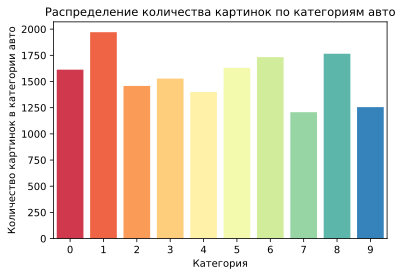

In [12]:
fig, ax = plt.subplots()
sns.barplot(y=train_df.Category.value_counts().values,
           x=train_df.Category.value_counts().index,saturation=10,
           palette="Spectral")
ax.set_ylabel('Количество картинок в категории авто',fontsize=10)
ax.set_xlabel('Категория',fontsize=10)
ax.set_title('Распределение количества картинок по категориям авто',fontsize=11.5)

# распределение классов достаточно равномерное - это хорошо

### 3.2. Визуальный анализ картинок

Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обрабатывать и сжимать.

Пример картинок


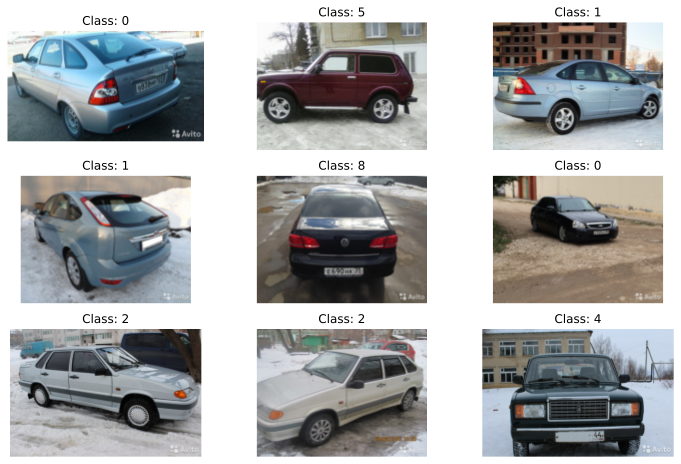

In [13]:
print('Пример картинок')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH_to_WORKDIR+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Картинки представлены разного размера

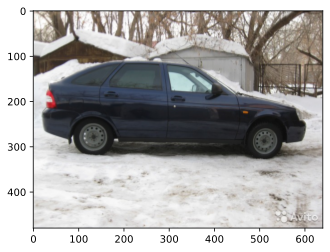

(640, 480)

In [14]:
#Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обрабатывать и сжимать.
image = PIL.Image.open(PATH_to_WORKDIR+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

**Предварительные итоги:**
* Для классификации представлены фотографии 10 категорий авто VAZ, Volkswagen, Ford   
   1. 0 категория = Lada Priora
   2. 1 категория = Ford Focus
   3. 2 категория = Lada Samara 2114
   4. 3 категория = Lada 2110
   5. 4 категория = Lada 2107
   6. 5 категория - Niva
   7. 6 категория - Lada Kalina
   8. 7 категория - Lada 2109
   9. 8 категория - Volkswagen Passat
   10. 9 категория - Lada Samara 21099
* Категории достаточно сбалансированны по кол-ву фото
* Размеры фотографий различаются, но в основном 640 на 480. Цветные.
* Всего 22236 фото в том числе: 15561 в трейне и 6675 в тесте
* Кол-во фото в трейне не достаточно для хорошего обучения модели нейронной сети, поэтому будем применять различные виды аугментации данных

# 4.

## 4.1 Аугментация данных

In [15]:
! pip install git+https://github.com/mjkvaak/ImageDataAugmentor
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

try:
    from ImageDataAugmentor.image_data_augmentor import *
except:
    import sys
    sys.path.append("..")
    from ImageDataAugmentor.image_data_augmentor import *

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-7f2pc3hl
  Running command git clone --filter=blob:none --quiet https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-7f2pc3hl
  Resolved https://github.com/mjkvaak/ImageDataAugmentor to commit 9f16ebd3e667cc16cde49f1ec1e5211e7962cd5c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 897.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 15.9 MB/s eta 0:00:0000:0100:01
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29644 sha256=e9a5db1b0f98c40ad3ca703132049406e780ac706a5307b47157f3be5610f5b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-zm_nsd6i/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling openc

In [16]:
# Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай!
# Чтобы лучше понять работу параметров, можно попробовать их поизменять.
# Официальная документация: https://keras.io/preprocessing/image/
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05), # размытие
    A.RandomBrightness(limit=0.2, p=0.5),#изменение яркости входного изображения
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.01, interpolation=1, 
                       border_mode=4, rotate_limit=20, p=0.75),# произвольные преобразования: поворот ,масштаб,перевод
    A.OneOf([A.CenterCrop(height=224, width=200),A.CenterCrop(height=200, width=224)],p=0.5),# обрезка
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit= 0.3, contrast_limit=0.3),#Произвольное изменение яркости и контрастности входного изображения
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)], p=0.5),
    A.HorizontalFlip(p=0.5), # отражение по горизонтале
    A.HueSaturationValue(p=0.5,hue_shift_limit=(-10, 50),sat_shift_limit=(-15, 15),val_shift_limit=(-10,5)), #Произвольное изменение оттенка, насыщенности и значения входного изображения.
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    A.Resize(224, 320) #Измените размер ввода на заданную высоту и ширину
])

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [17]:
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

test_datagen = ImageDataGenerator(rescale=1. / 255)

## 4.2 Генерация данных

In [18]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH_to_WORKDIR+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH_to_WORKDIR+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=df_submis,
    directory=PATH_to_WORKDIR+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)
# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe.

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:333: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Посмотрим как изменились картинки

Пример картинок из train_generator


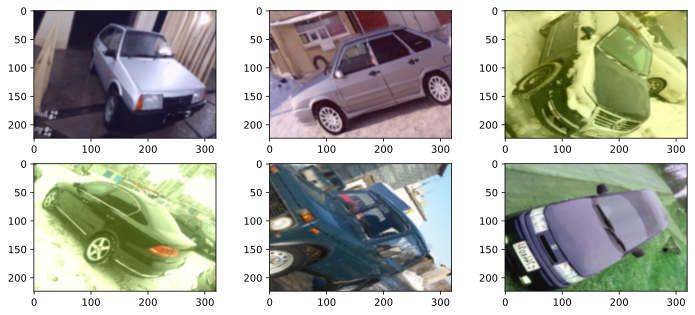

In [19]:
#  Глянем на аугментированные каритнки train

from skimage import io
def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next() # вызываем трейн-генератор
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


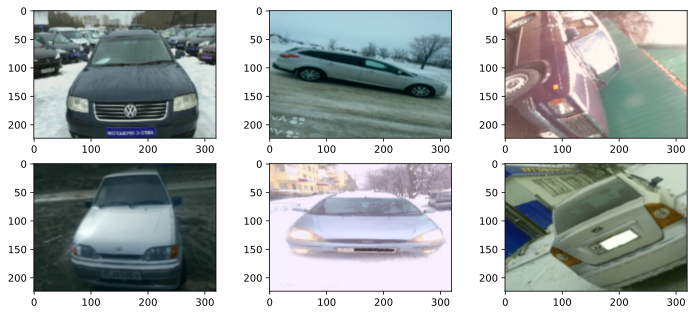

In [20]:
#  Глянем на аугментированные каритнки test
x,y = test_generator.next() # вызываем тест-генератор
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

## Обратный вызов Callbackss

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
MODEL = "efficient-b6"
MODEL_PATH = '/kaggle/working'
def make_callbacks():
    
    callback_early_stopping = EarlyStopping(monitor='accuracy',patience=2, verbose=1)
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,min_lr=1e-10,patience=0,verbose=1)
    callback_learing_rate = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x),
    path_checkpoint = 'checkpoint.keras'
    callback_checkpoint = ModelCheckpoint(f'{MODEL}_best.hdf6' , monitor = ['val_acc'] , verbose = 1  , mode = 'max') 
    #ModelCheckpoint(filepath=path_checkpoint,monitor='val_loss',verbose=1,save_weights_only=True, save_best_only=True)

    return [callback_checkpoint,
            callback_learing_rate,
                 callback_reduce_lr]

callbacks = make_callbacks()

# Построение модели

In [22]:
input_shape

(320, 320, 3)

В keras есть дополнительная функция tf.keras.applications, которая позволяет подгрузить уже готовую модель с весами. Если посмотреть в документации функции, там доступны различные модели.  Но мы воспользуемся EfficientNetB6 - у нее достаточно приемлемое качество.

Подгрузим веса (weights='imagenet') предобученные на имадженете

не будем использовать выходы, которые использовались на имедженете(include_top=False)

и указываем размер картинок input_shape=input_shape 

In [23]:
#base_model = Xception(weights='imagenet', 
#                      include_top=False, 
#                      input_shape = input_shape)

#base_model = InceptionV3(weights='imagenet', 
#                         include_top=False, 
#                         input_shape = input_shape)

# base_model = efn.EfficientNetB5(weights='imagenet', 
#                                 include_top=False, 
#                                 input_shape = input_shape)

# Загрузка модели efficientnet
!pip install -q efficientnet
import efficientnet.tfkeras as efn
# подгружаем предобученую сеть EfficientNetB6
base_model = efn.EfficientNetB6(weights='imagenet',include_top=False,input_shape = input_shape)


2022-11-11 08:52:29.421293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 08:52:29.517589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 08:52:29.518461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 08:52:29.520411: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

165535744/165527152 [==============================] - 5s 0us/step


In [24]:
base_model.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 160, 160, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 160, 160, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 160, 160, 56) 0           stem_bn[0][0]                    
____________________________________________________________________________________

подгрузились веса.
Смотрим саму модель.
Как видим, достаточно обьемная модель

In [25]:
# Для начала заморозим веса EfficientNetB6 и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения
base_model.trainable = False

## Далее, так сказать, утанавливаем "свою голову".

In [26]:
model = M.Sequential()
model.add(base_model) # указываем что соединяем base_model
model.add(L.GlobalAveragePooling2D(),)# делаем GAP который объединяет все признаки в единный вектор

# и далее устанавливаем  Dense слой,BatchNormalization,Dropout, и еще Dense слой.
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

# впринципе, если сеть достаточно хороша, то достаточно одного денс-слоя. 

In [27]:
#смотрим что за сеть в итоге.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 10, 10, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 593,162
Non-trainable params: 40,960,648
______________________________________

In [28]:
# сколько слоев
print(len(model.layers))

6


In [29]:
# сколько слоев обучилось
len(model.trainable_variables)

6

# Обучение модели

### 1. Замораживаем базовую часть модели полностью

In [30]:
callbacks = make_callbacks()

In [31]:
#LR=0.0001 задали выше
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

Так же воспользуемся функцией колбеков в кераси, это очень удобная вещь, она позваляет делать нам множество вещей во время обучения, одна из них - это можно делать чекпоинты (например,если у нас улучшился результат, то мы можем сохранить нашу модель, чтобы в дальнейшем подгрузить только самую успешную модель).

Так же у нас есть EarlyStopping - мы останавливаемся если наша модель уже не обучается дольше patience=5 интераций.

In [32]:
# Добавим ModelCheckpoint. 
# Эта функция позволяет сохранять прогресс обучения модели, 
# чтобы в нужный момент можно было его подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('best_model.hdf6', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 5,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [33]:
#проверили нашу модель по точности сейчас с рандомными весами. 15.6%
scores = model.evaluate(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

2022-11-11 08:52:44.062953: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-11 08:52:50.266051: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1/1 [==============================] - 12s 12s/step - loss: 2.2502 - accuracy: 0.1562
Accuracy: 15.62%


теперь обучим нашу модель

In [34]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list)

Epoch 1/12
413/413 [==============================] - 258s 591ms/step - loss: 2.1731 - accuracy: 0.2961 - val_loss: 1.4934 - val_accuracy: 0.4688

Epoch 00001: saving model to best_model.hdf6


2022-11-11 08:57:48.601611: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/12
413/413 [==============================] - 252s 609ms/step - loss: 1.7330 - accuracy: 0.4062 - val_loss: 1.2945 - val_accuracy: 0.5464

Epoch 00002: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/12
413/413 [==============================] - 239s 579ms/step - loss: 1.5875 - accuracy: 0.4457 - val_loss: 1.2259 - val_accuracy: 0.5673

Epoch 00003: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/12
413/413 [==============================] - 237s 574ms/step - loss: 1.5352 - accuracy: 0.4686 - val_loss: 1.1940 - val_accuracy: 0.5781

Epoch 00004: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/12
413/413 [==============================] - 240s 582ms/step - loss: 1.4832 - accuracy: 0.4805 - val_loss: 1.1384 - val_accuracy: 0.5998

Epoch 00005: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/12
413/413 [==============================] - 241s 584ms/step - loss: 1.4482 - accuracy: 0.4945 - val_loss: 1.1109 - val_accuracy: 0.6120

Epoch 00006: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/12
413/413 [==============================] - 239s 579ms/step - loss: 1.3900 - accuracy: 0.5155 - val_loss: 1.1136 - val_accuracy: 0.5955

Epoch 00007: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/12
413/413 [==============================] - 241s 583ms/step - loss: 1.3530 - accuracy: 0.5269 - val_loss: 1.0536 - val_accuracy: 0.6319

Epoch 00008: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/12
413/413 [==============================] - 251s 607ms/step - loss: 1.3535 - accuracy: 0.5248 - val_loss: 1.0583 - val_accuracy: 0.6254

Epoch 00009: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/12
413/413 [==============================] - 246s 595ms/step - loss: 1.3156 - accuracy: 0.5352 - val_loss: 1.0318 - val_accuracy: 0.6337

Epoch 00010: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/12
413/413 [==============================] - 245s 592ms/step - loss: 1.2874 - accuracy: 0.5458 - val_loss: 1.0206 - val_accuracy: 0.6328

Epoch 00011: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/12
413/413 [==============================] - 246s 596ms/step - loss: 1.2637 - accuracy: 0.5515 - val_loss: 1.0224 - val_accuracy: 0.6285

Epoch 00012: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [35]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf6')
model.load_weights('best_model.hdf6')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-11-11 10:07:32.682789: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open best_model.hdf6: Failed precondition: best_model.hdf6; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


И проверяем точность

In [36]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

73/73 [==============================] - 36s 489ms/step - loss: 0.9851 - accuracy: 0.6466
Accuracy: 64.66%


В Итоге точность нашей модели составила 64.66%. 


Посмотрим графики обучения:

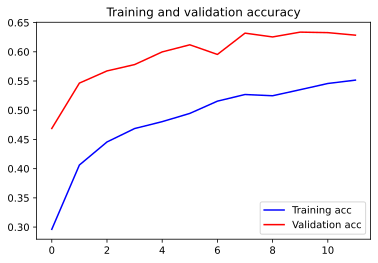

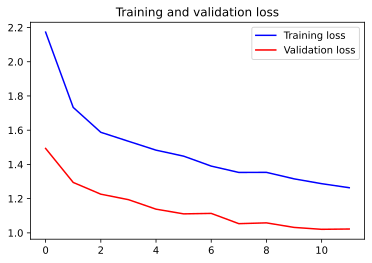

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### 2. Fine-tuning  Разморозка половины слоев базовой модели

суть дообучения (Fine Tuning) заключается в размораживании последних слоев нейронной сети (Neural Net) и их обучении. Таким образом, корректируются слои, которые имеют наиболее абстрактные представления. Производя дообучение только нескольких слоев, мы уменьшаем риск переобучения (overfitting). И самое главное, это позволяет сделать текущую модель ещё более подходящей к нашей задаче.

In [38]:
# Давайте посмотрим, сколько слоев в базовой модели
len(base_model.layers)

659

In [39]:
# начинаем постепенную разморозку слоев для базовой модели для обучения
base_model.trainable = True

fine_tune_at = len(base_model.layers)//2 # количество слоев, которые будут обучаться

# Заморозим все слои перед слоем `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [40]:
len(base_model.trainable_variables)

291

In [41]:
LR=0.00001
model.compile(loss="categorical_crossentropy",
              optimizer = optimizers.Adam(learning_rate = LR), 
              metrics = 'accuracy')

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 10, 10, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 38,289,632
Non-trainable params: 3,264,178
____________________________________

In [ ]:
history = model.fit(
    train_generator, 
    steps_per_epoch = len(train_generator), 
    validation_data = test_generator, 
    validation_steps = len(test_generator), 
    epochs = EPOCHS, 
    callbacks = callbacks_list
)

Epoch 1/12
414/414 [==============================] - 296s 669ms/step - loss: 1.8841 - accuracy: 0.3837 - val_loss: 1.3434 - val_accuracy: 0.5260

Epoch 00001: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/12
414/414 [==============================] - 269s 650ms/step - loss: 1.5670 - accuracy: 0.4589 - val_loss: 1.1435 - val_accuracy: 0.5912

Epoch 00002: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/12
414/414 [==============================] - 267s 645ms/step - loss: 1.3783 - accuracy: 0.5187 - val_loss: 0.9902 - val_accuracy: 0.6479

Epoch 00003: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/12
414/414 [==============================] - 270s 650ms/step - loss: 1.2296 - accuracy: 0.5599 - val_loss: 0.9059 - val_accuracy: 0.6672

Epoch 00004: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/12
414/414 [==============================] - 271s 653ms/step - loss: 1.1364 - accuracy: 0.5963 - val_loss: 0.8059 - val_accuracy: 0.7029

Epoch 00005: saving model to best_model.hdf6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/12
414/414 [==============================] - ETA: 0s - loss: 1.0430 - accuracy: 0.6270

In [ ]:
model.save('../working/model_last.hdf6')
model.load_weights('best_model.hdf6')

In [ ]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### 3. Разморозим больше слоев

In [ ]:
base_model.trainable = True

fine_tune_at = len(base_model.layers)//4

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
len(base_model.trainable_variables) 

In [ ]:
LR = 1e-5
model.compile(loss="categorical_crossentropy", 
              optimizer = optimizers.Adam(learning_rate = LR), 
              metrics = 'accuracy')

In [ ]:
model.summary()

In [ ]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 20,
        callbacks = callbacks_list
)

In [ ]:
model.save('../working/model_last.hdf6')
model.load_weights('best_model.hdf6')

In [ ]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### 4. Разморозим полностью

In [ ]:
base_model.trainable = True
model.compile(loss="categorical_crossentropy",
              optimizer = optimizers.Adam(learning_rate = LR), 
              metrics = 'accuracy')

In [ ]:
history = model.fit(
    train_generator, 
    steps_per_epoch = len(train_generator), 
    validation_data = test_generator, 
    validation_steps = len(test_generator), 
    epochs = 12, 
    callbacks = callbacks_list
)

In [ ]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
model.save('../working/model_last.hdf6')
model.load_weights('best_model.hdf6')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Submission

In [ ]:
test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

In [ ]:
submission.head()

## 5. IMG_SIZE rise

In [ ]:
# изменим некоторые параметры
EPOCHS               = 8
BATCH_SIZE           = 8 
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [ ]:
AUGMENTATIONS = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.07, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, interpolation=1, border_mode=4, 
             value=None, mask_value=None, always_apply=False, p=0.5),
])

In [ ]:
train_gen2 = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )
test_gen2 = ImageDataAugmentor(rescale=1./255)


# data generators
train_generator_2 = train_gen2.flow_from_directory(
        PATH_to_WORKDIR+'train/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True, 
        seed=RANDOM_SEED,
        subset='training')

test_generator_2 = test_gen2.flow_from_directory(
        PATH_to_WORKDIR+'train/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True, 
        seed=RANDOM_SEED,
        subset='validation')

test_sub_generator_2 = test_datagen.flow_from_dataframe( 
    dataframe=df_submis,
    directory=PATH_to_WORKDIR+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

In [ ]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
# Устанавливаем новую "голову" (head)

model = Model.Sequential()
model.add(base_model)

model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())  

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(CLASS_NUM, activation='softmax'))

model.compile(loss="categorical_crossentropy", 
               optimizer=optimizers.Adam(learning_rate=LR), 
               metrics=["accuracy"],
               )

In [ ]:
# Загружаем веса уже обученной модели
model.load_weights('best_model.hdf6')

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=2, min_lr=0.0000001, verbose=1,
                             mode='auto')

callbacks_list = [checkpoint,earlystop,reduce_lr]

In [ ]:
history = model.fit(
        train_generator_2,
        steps_per_epoch = train_generator_2.samples//train_generator_2.batch_size,
        validation_data = test_generator_2, 
        validation_steps = test_generator_2.samples//test_generator_2.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
scores = model.evaluate(test_generator_2, steps=len(test_generator_2), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## sabmission после увеличения размера картинки

In [ ]:
test_sub_generator_2.reset()
predictions = model.predict(test_sub_generator_2, steps=len(test_sub_generator_2), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator_2.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')

In [ ]:
submission.to_csv('submission_IMG_SIZE.csv', index=False)

## 6. Test Time Augmentation

https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Аугментируем тестовые изображения и сделаем несколько предсказаний одной картинки в разном виде. Взяв среднее значение из нескольких предсказаний получим итоговое предсказание.

In [ ]:
model.load_weights(f'{MODEL}_best.hdf6')

In [ ]:
AUGMENTATIONS = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    A.OneOf([
        A.CenterCrop(height=220, width=200),
        A.CenterCrop(height=200, width=220),
    ],p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    A.GaussianBlur(p=0.05),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    A.Resize(200, 160)
])

In [ ]:
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=df_submis,
    directory=PATH_to_WORKDIR+'/test_upload',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

In [ ]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

In [ ]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)


In [ ]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Clean 
import shutil
shutil.rmtree(PATH_to_WORKDIR)